![alt text](https://i0.wp.com/articolidiastronomia.com/wp-content/uploads/2021/01/cropped-cropped-icona-21-2.jpeg?w=1600&ssl=1)

In [342]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [344]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from skyfield.api import Star, load
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection

import folium
from folium import plugins
from folium.plugins import HeatMap
import os
import geopy
import json

from datetime import date
import datetime

from colorama import Fore
from colorama import Style

import datetime, io, skyfield.api, skyfield.constants, skyfield.data.mpc
import geocoder

## Input information

Select the **celestial body**

In [345]:
body = "C/2020 F3 (NEOWISE)"

Select the **location**

In [346]:
location = 'Villasanta Via Bestetti, Italy'
label='GAV Gruppo Astrofili Villasanta'

Select **starting date of analysis**

In [347]:
date_min = '2021-01-01'

## Start analysis

Retrieve the geo coordinates

In [348]:
latitude, longitude = geocoder.arcgis(location).latlng    

In [349]:
map_world = folium.Map(location=[latitude, longitude], titles = 'Stamen Terrain', zoom_start=15)
folium.CircleMarker(
    [latitude, longitude],
    radius=7,
    popup=label,
    fill=True,
    color='Red',
    fill_color='Blue',
    fill_opacity=0.9
    ).add_to(map_world)

map_world

In [350]:
today = date.today()
date_max = today.strftime("%Y-%m-%d")

**Recap of the input data**

In [351]:
date_min_obj = datetime.datetime.strptime(date_min, '%Y-%m-%d')
date_max_obj = datetime.datetime.strptime(date_max, '%Y-%m-%d')

delta = date_max_obj - date_min_obj

print (f'Analysis of body: {Fore.MAGENTA} %s {Style.RESET_ALL}' % body)
print (f'Period of analysis: {Fore.MAGENTA} [%s, %s] {Style.RESET_ALL}' % (str(date_min), str(date_max)))
print (f'Total days: {Fore.MAGENTA} %2d {Style.RESET_ALL}' % (delta.days))
print (f'Observation point: {Fore.MAGENTA} [%f, %f] {Style.RESET_ALL}' % (latitude, longitude))

Analysis of body:  C/2020 F3 (NEOWISE) 
Period of analysis:  [2021-01-01, 2021-02-23] 
Total days:  53 
Observation point:  [45.603195, 9.300567] 


In [352]:
ts = load.timescale()
t_comet = ts.utc(date_min_obj.year, date_min_obj.month, range(delta.days)) 

Load Solar System Dynamics file from JPL for Guidance, Navigation, and Control section. See following links: 

* https://naif.jpl.nasa.gov/pub/naif/JUNO/kernels/spk/de421.bsp.lbl 
* https://naif.jpl.nasa.gov/pub/naif/JUNO/kernels/spk/

In [353]:
t = t_comet[len(t_comet) // 2]  # center the ts period

eph = load('de421.bsp')
sun = eph['sun']
earth = eph['earth']

In [354]:
with load.open(mpc.COMET_URL) as f:
    comets = mpc.load_comets_dataframe(f)

comets = (comets.sort_values('reference')
          .groupby('designation', as_index=False).last()
          .set_index('designation', drop=False))

comets.head()

,designation,perihelion_year,perihelion_month,perihelion_day,perihelion_distance_au,eccentricity,argument_of_perihelion_degrees,longitude_of_ascending_node_degrees,inclination_degrees,magnitude_g,magnitude_k,reference
designation,,,,,,,,,,,,
100P/Hartley,100P/Hartley,2022,8,10.9630,2.016718,0.412401,181.9959,37.7053,25.5664,9.0,4.0,MPEC 2013-O31
101P/Chernykh,101P/Chernykh,2020,1,12.5697,2.344737,0.595862,277.6987,116.2308,5.0528,12.0,4.8,MPC115887
102P/Shoemaker,102P/Shoemaker,2021,1,22.3907,2.069919,0.457148,20.5390,339.3659,25.8848,6.5,8.0,MPC 86232
103P/Hartley,103P/Hartley,2023,10,12.9960,1.066782,0.693126,181.2855,219.7293,13.5985,8.5,8.0,MPEC 2018-HA5
104P/Kowal,104P/Kowal,2022,1,10.9880,1.071947,0.665932,227.0070,207.5134,5.7176,16.0,4.0,MPC100283


Show the **orbital parameters** of the target object

In [355]:
row = comets.loc[body]
row

designation                            C/2020 F3 (NEOWISE)
perihelion_year                                       2020
perihelion_month                                         7
perihelion_day                                      3.6766
perihelion_distance_au                            0.294705
eccentricity                                      0.999178
argument_of_perihelion_degrees                      37.267
longitude_of_ascending_node_degrees                 61.013
inclination_degrees                                128.931
magnitude_g                                           12.5
magnitude_k                                            3.2
reference                                    MPEC 2020-L06
Name: C/2020 F3 (NEOWISE), dtype: object

* From **Hipparcos catalog** retrieves star catalog
* From **Stellarium** retrieves the Wester constellation culture

In [356]:
comet = sun + mpc.comet_orbit(row, ts, GM_SUN)

with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master/skycultures/western_SnT/constellationship.fab')

with load.open(url) as f:
    constellations = stellarium.parse_constellations(f)

edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

Center the chart on middle orbit of the target body

In [357]:
center = earth.at(t).observe(comet)
projection = build_stereographic_projection(center)

Set the field view and th max star magnitude in term of **field size** and **max star magnitude** 

In [364]:
field_of_view_degrees = 40.0
limiting_magnitude = 7.0

Draw the star chart with body trajectory

Text(0.5, 1.0, 'Comet NEOWISE 2020 December 31 through 2021 February 21')

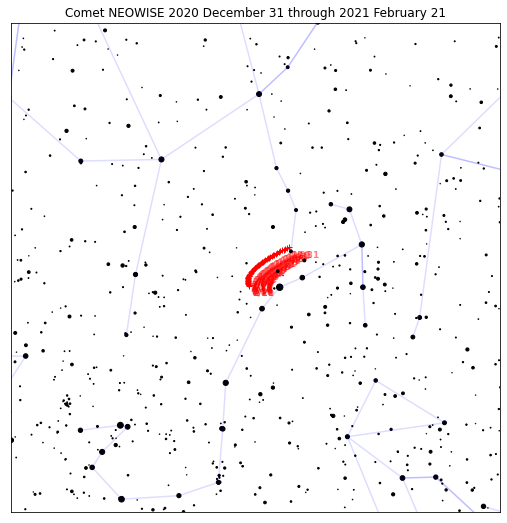

In [367]:
star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

comet_x, comet_y = projection(earth.at(t_comet).observe(comet))

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

fig, ax = plt.subplots(figsize=[9, 9])

# Draw the constellation lines.

ax.add_collection(LineCollection(lines_xy, colors='#00f2'))
ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
           s=marker_size, color='k')

# Draw the comet positions, and label them with dates.

comet_color = '#f00'
offset = 0.002

ax.plot(comet_x, comet_y, '+', c=comet_color, zorder=3)

step = 1

for xi, yi, tstr in zip(comet_x, comet_y, t_comet.utc_strftime('%m/%d')):
    step = step + 1
    tstr = tstr.lstrip('0')
    if ((step % 3) == 0):
        text = ax.text(xi + offset, yi - offset, tstr, color=comet_color,
                   ha='left', va='top', fontsize=9, weight='bold', zorder=-1)
    text.set_alpha(0.5)

# title

angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))

ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)
ax.set_title('Comet NEOWISE {} through {}'.format(
    t_comet[0].utc_strftime('%Y %B %d'),
    t_comet[-1].utc_strftime('%Y %B %d'),
))
